In [7]:
import os, h5py
import numpy as np
from tqdm.notebook import tqdm, trange

In [3]:
import torch 
from sbi import utils as Ut
from sbi import inference as Inference

In [4]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [5]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

seed = 12387
torch.manual_seed(seed)
if cuda: 
    torch.cuda.manual_seed(seed)

In [9]:
dat_dir = '/scratch/gpfs/chhahn/21cmlfi/'
f = h5py.File(os.path.join(dat_dir, '21cmlfi.hdf5'), 'r')

thetas = f['theta'][...]
obs = f['Del2_21_noise'][...]

f.close()

In [17]:
print('Ntrain = %i' % thetas.shape[0])

Ntrain = 124027


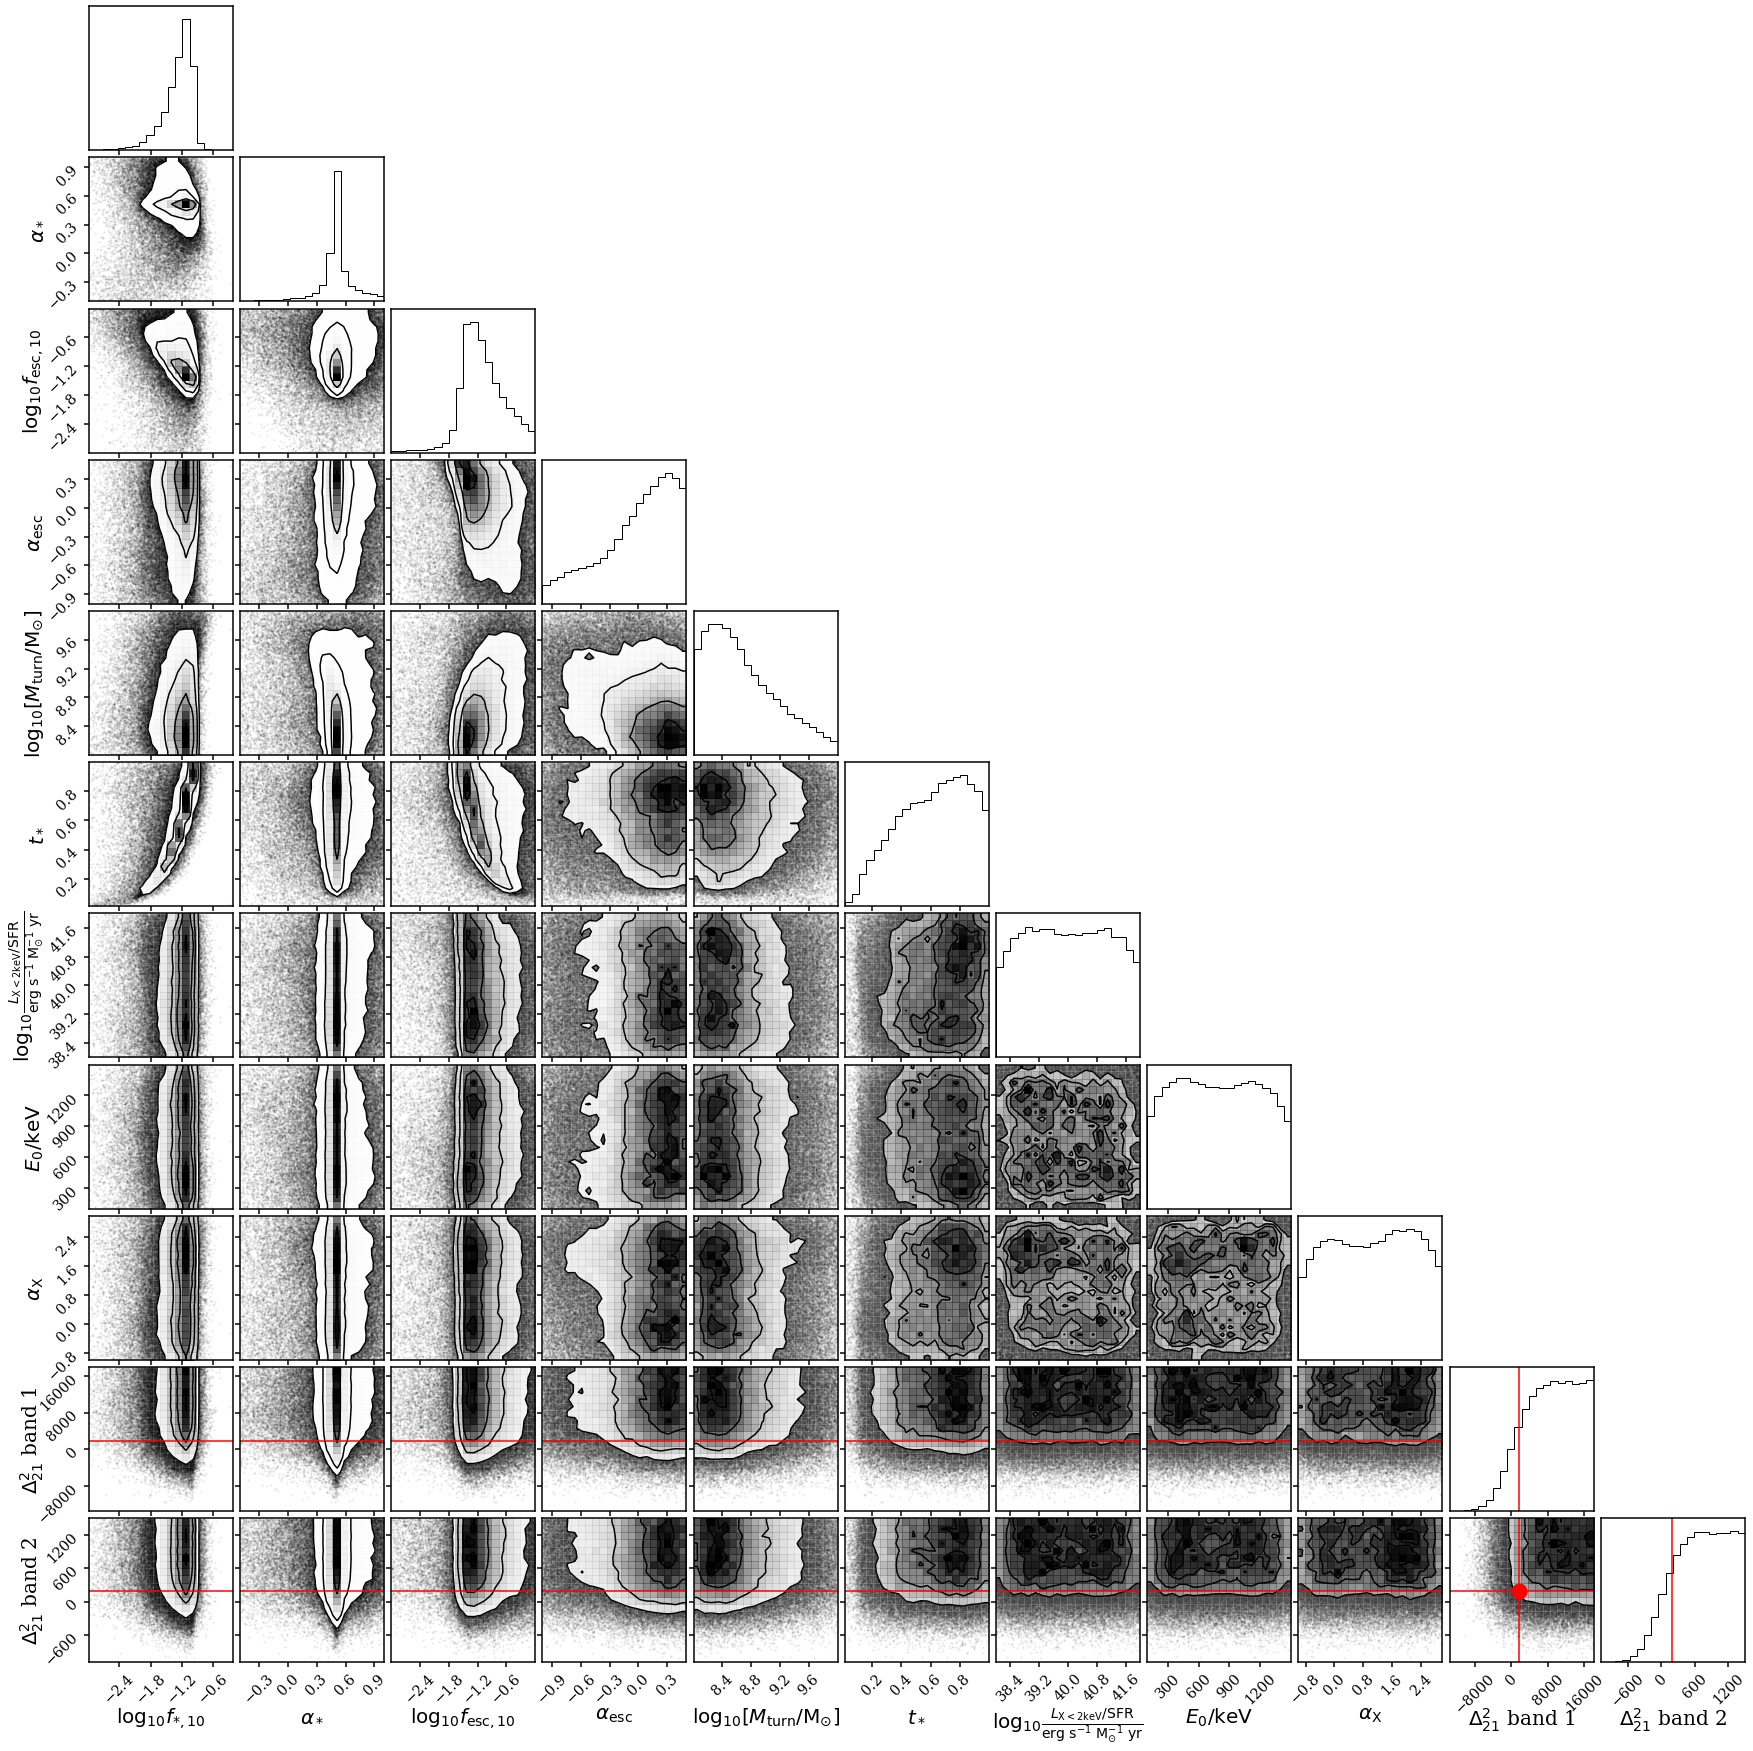

In [11]:
lbl_params = np.array([r"$\log_{10} f_{*,10}$",
                       r"$\alpha_*$",
                       r"$\log_{10} f_{\rm esc, 10}$",
                       r"$\alpha_{\rm esc}$",
                       r"$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$",
                       r"$t_*$",
                       r"$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$",
                       r"$E_0/{\rm keV}$",
                       r"$\alpha_{\rm X}$"])

prior_params = [[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]]

fig = DFM.corner(np.concatenate([thetas, obs], axis=1), 
                 labels=list(lbl_params) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
                 label_kwargs={'fontsize': 20})
DFM.overplot_points(fig, [[None for _ in lbl_params] + [1700, 200]], color='r', markersize=30)
DFM.overplot_lines(fig, [None for _ in lbl_params] + [1700, 200], color='r')

# train Neural Posterior Estimator

In [68]:
lower_bounds = torch.tensor([_p[0] for _p in prior_params])
upper_bounds = torch.tensor([_p[1] for _p in prior_params])

lower_bounds[-2] = 100.
upper_bounds[-2] = 1500.0

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

In [19]:
# train multiple NPEs and pick the best one
anpes, phats = [], []
valid_logprobs, best_valid_logprobs = [], []
archs = []
for i in range(1):
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(512)))))
    nblocks = int(np.random.uniform(3, 10))
    print('MAF with nhidden=%i; nblocks=%i' % (nhidden, nblocks))
    archs.append('%ix%i' % (nhidden, nblocks))

    anpe = Inference.SNPE(prior=prior,
                          density_estimator=Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks),
                          device=("cuda" if cuda else "cpu"))
    #, summary_writer=SummaryWriter('/home/chhahn/projects/simbig/cmass/bin/inference/o/npe.%s.kmax%.1f' % (sumstat, kmax)))

    anpe.append_simulations(
        torch.as_tensor(thetas.astype(np.float32)),
        torch.as_tensor(obs.astype(np.float32)))

    _phat = anpe.train(training_batch_size=512)

    p_theta_obs_est = anpe.build_posterior(_phat)
    
    anpes.append(anpe)
    phats.append(p_theta_obs_est)

    valid_logprobs.append(anpe._summary['validation_log_probs'])
    best_valid_logprobs.append(anpe._summary['best_validation_log_probs'])

ibest = np.argmax(best_valid_logprobs)
best_anpe = anpes[ibest]
best_phat = phats[ibest]
best_arch = archs[ibest]

MAF with nhidden=142; nblocks=3
 Neural network successfully converged after 170 epochs.

In [72]:
# sample posterior p(theta | x)
mcmc_npe = []
for i in trange(1000): 
    _mcmc_npe = best_phat.sample((1,),
        x=torch.as_tensor(obs[i*100].astype(np.float32)).to('cpu'),
        show_progress_bars=False)
    mcmc_npe.append(np.array(_mcmc_npe.detach().to('cpu')))
    #print(mcmc_npe[-1], _obs)
mcmc_npe = np.array(mcmc_npe)

  0%|          | 0/1000 [00:00<?, ?it/s]

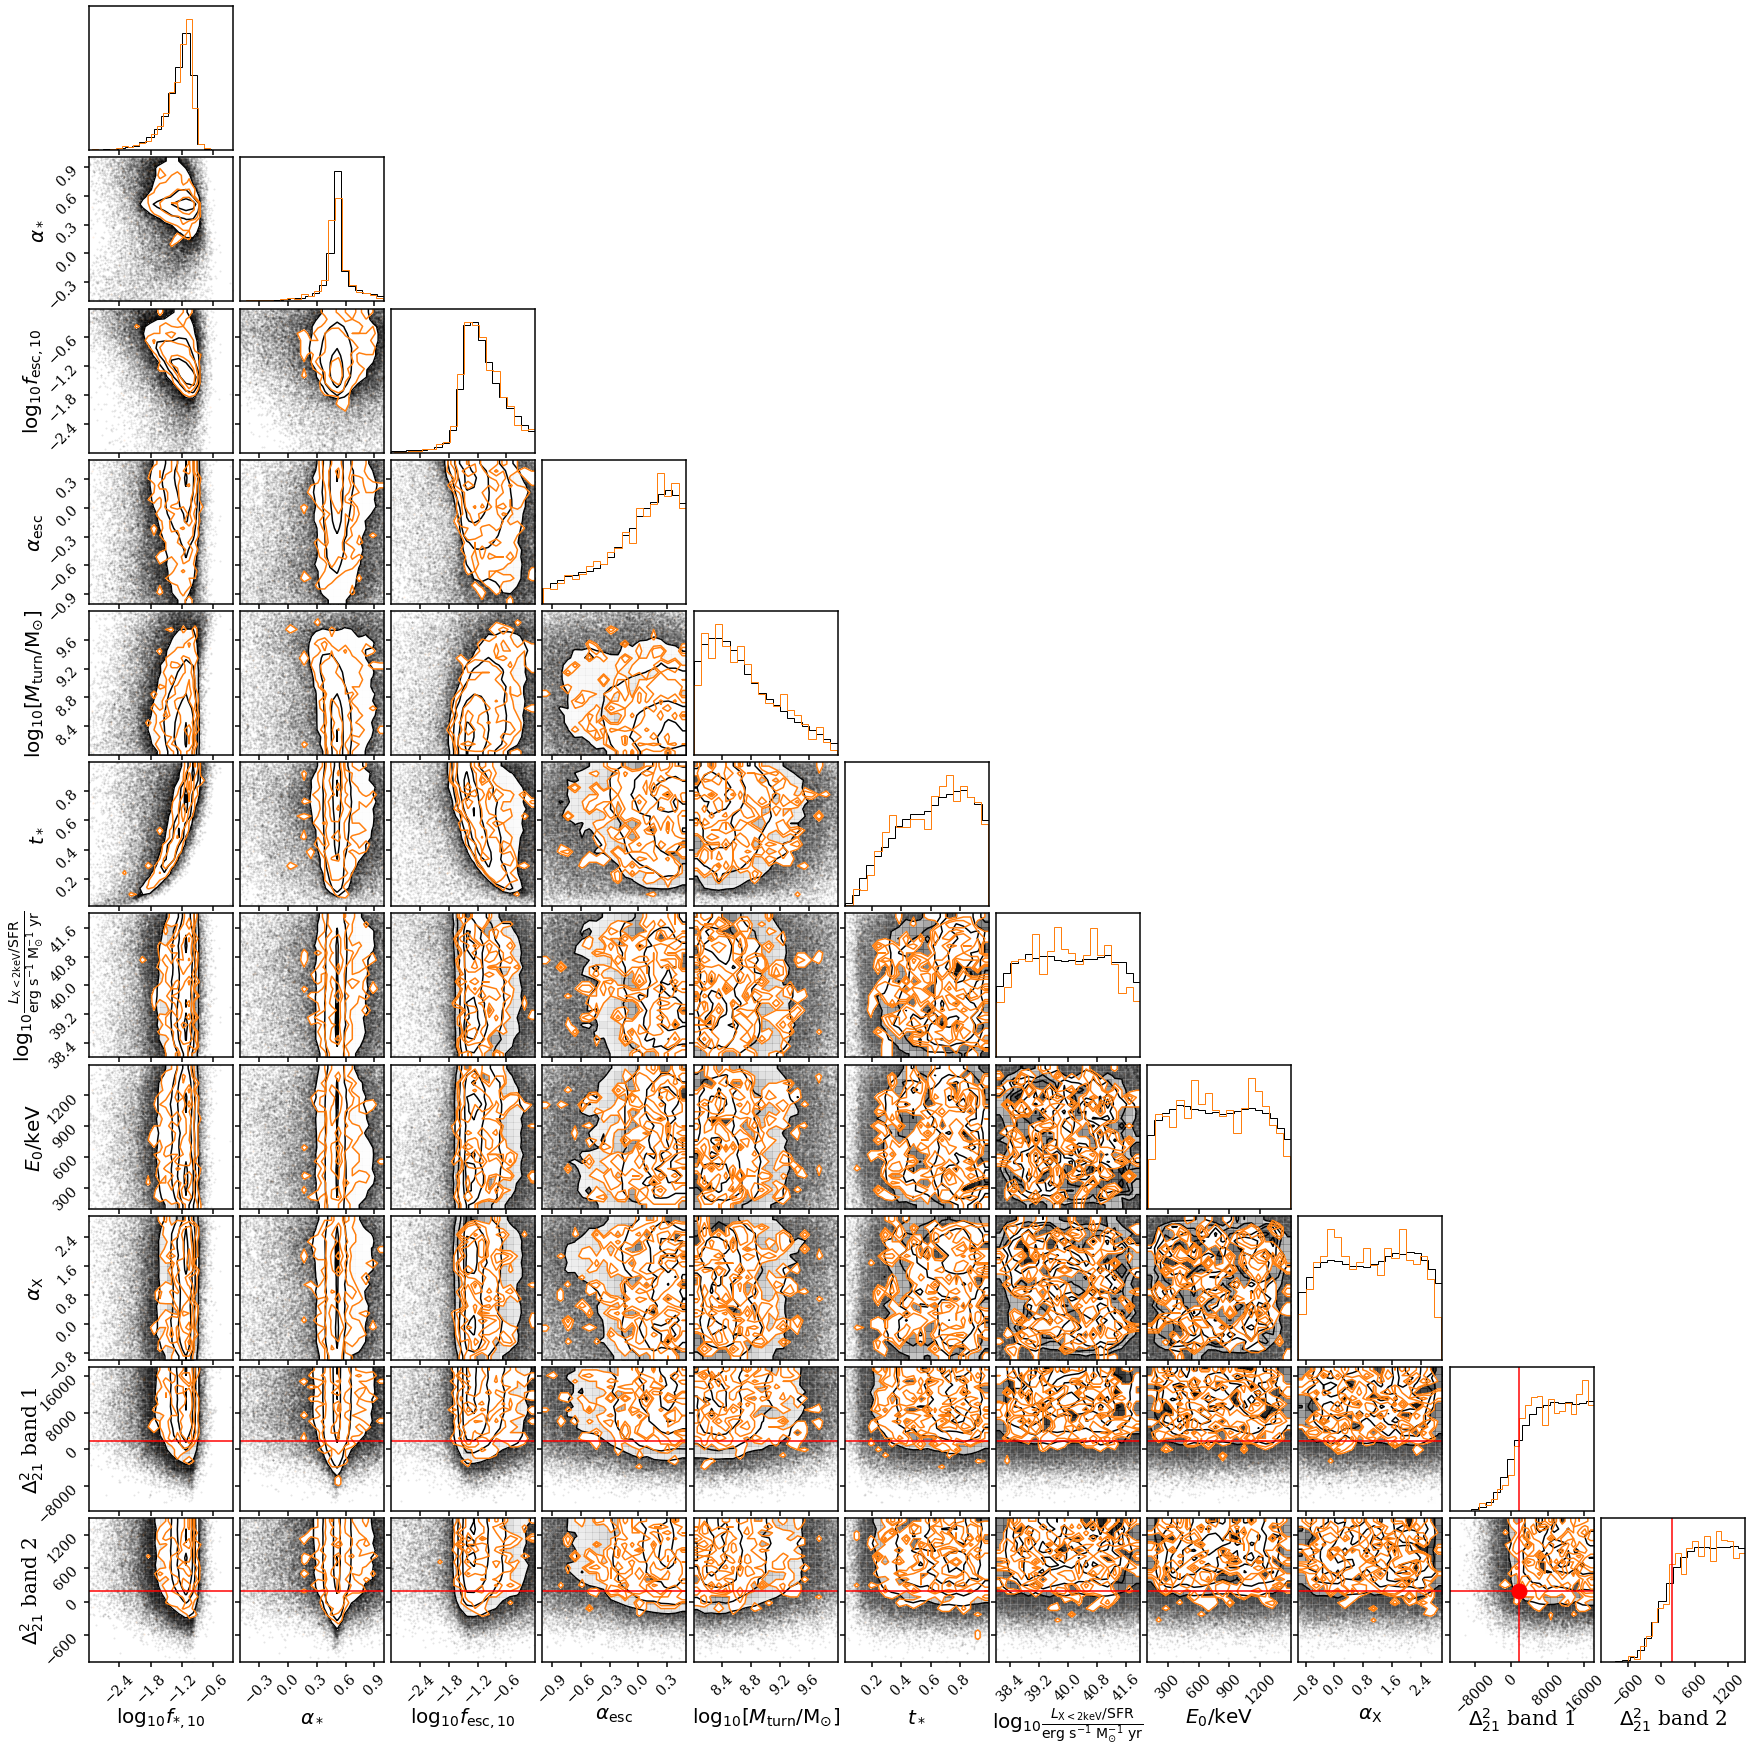

In [80]:
fig = DFM.corner(np.concatenate([thetas, obs], axis=1), 
                 labels=list(lbl_params) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True})

_ = DFM.corner(np.concatenate([mcmc_npe[:,0,:], obs[::100][:1000]], axis=1), fig=fig, 
               labels=list(lbl_params) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
               label_kwargs={'fontsize': 20}, color='C1', plot_density=False, 
               hist_kwargs={'density': True})
DFM.overplot_points(fig, [[None for _ in lbl_params] + [1700, 200]], color='r', markersize=30)
DFM.overplot_lines(fig, [None for _ in lbl_params] + [1700, 200], color='r')

# derive posterior for measurement
$${\bf x} = [1700, 200]$$

In [82]:
# sample posterior p(theta | x)
mcmc_npe = best_phat.sample((10000,),
        x=torch.as_tensor(np.array([1700., 200.]).astype(np.float32)).to('cpu'),
        show_progress_bars=True)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

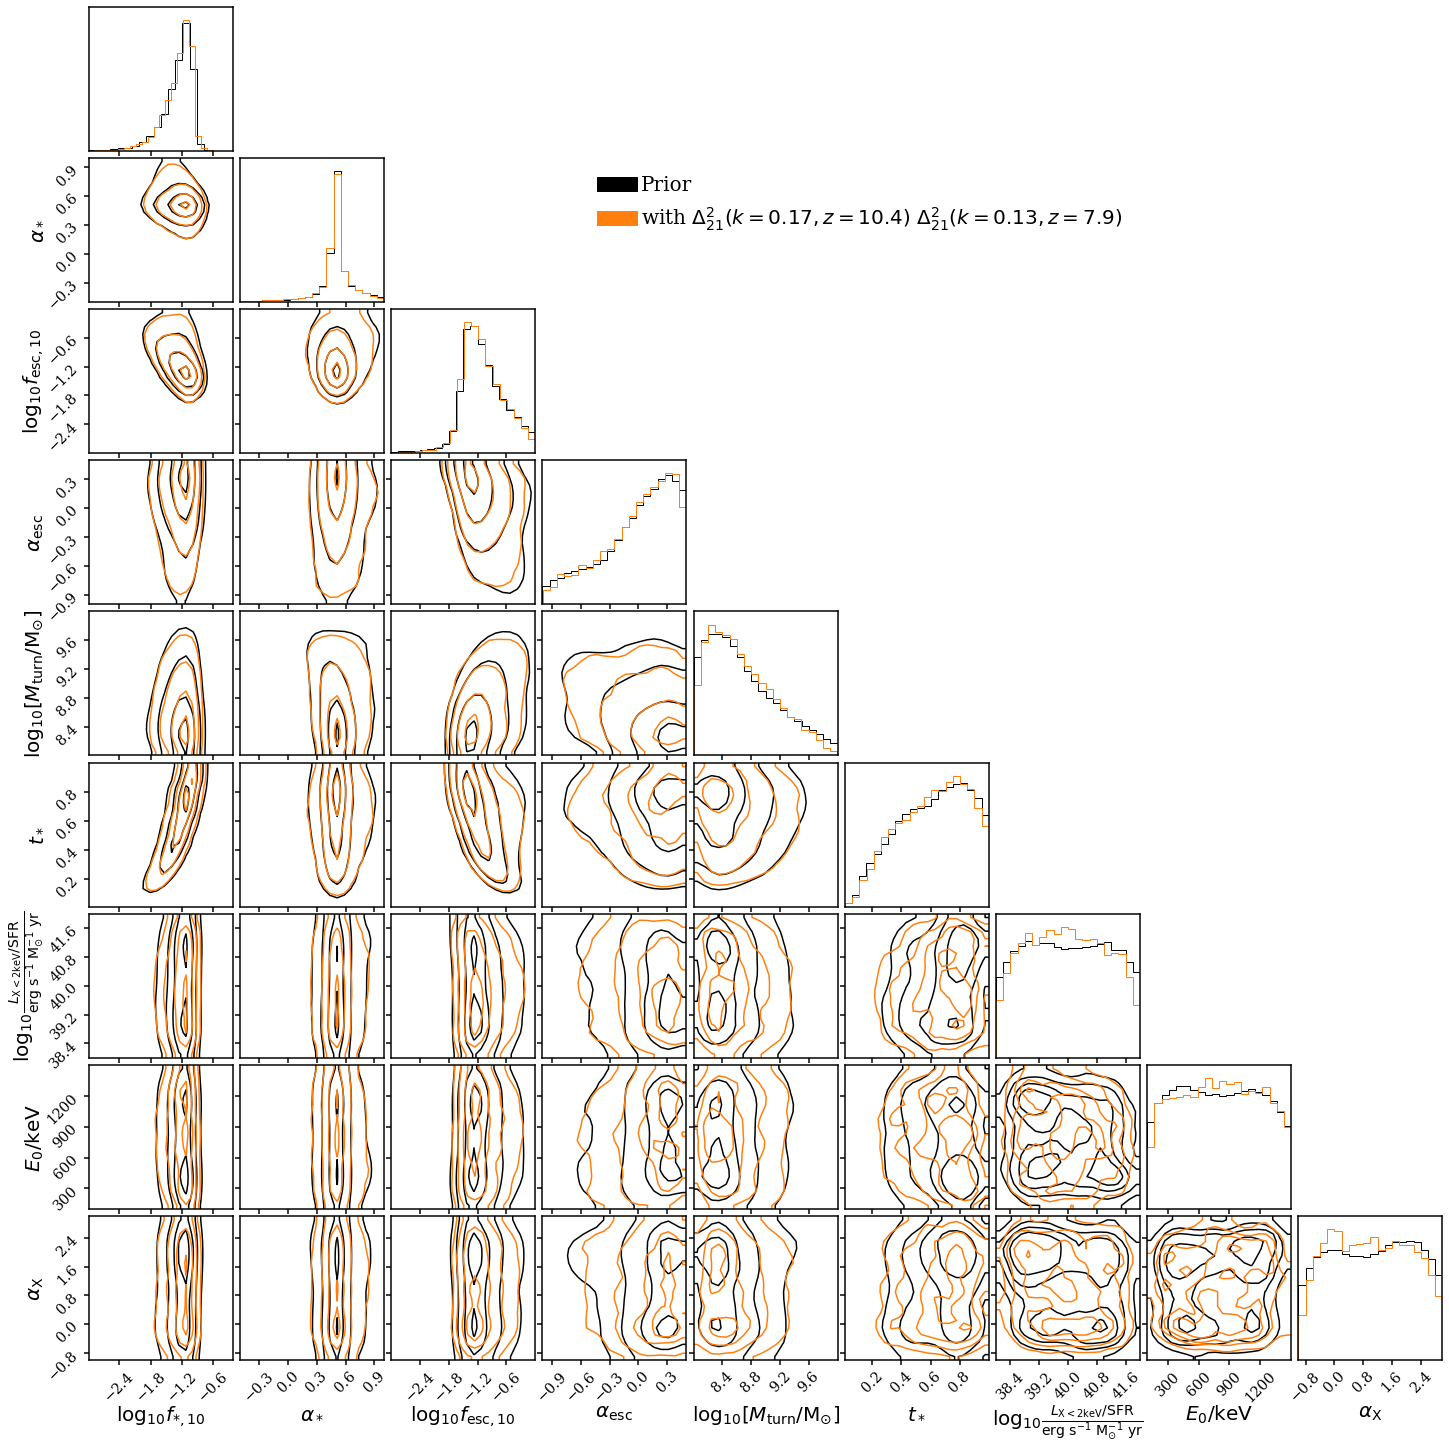

In [100]:
fig = DFM.corner(thetas, 
                 labels=lbl_params,
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False)
_ = DFM.corner(np.array(mcmc_npe.detach().to('cpu')), color='C1', 
                 labels=lbl_params,
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 9
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[1, ndim-3]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C1', label=r'with $\Delta_{21}^2(k=0.17, z=10.4)$ $\Delta_{21}^2(k=0.13, z=7.9)$')
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)